**Note**: Click on "*Kernel*" > "*Restart Kernel and Clear All Outputs*" in [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) *before* reading this notebook to reset its output. If you cannot run this file on your machine, you may want to open it [in the cloud <img height="12" style="display: inline-block" src="../static/link/to_mb.png">](https://mybinder.org/v2/gh/webartifex/intro-to-python/develop?urlpath=lab/tree/11_classes/03_content.ipynb).

# Chapter 11: Classes & Instances (continued)

The implementations of our `Vector` and `Matrix` classes so far do not know any of the rules of [linear algebra <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Linear_algebra). In this third part of the chapter, we add a couple of typical vector and matrix operations, for example, vector addition or matrix-vector multiplication, and some others. Before we do so, we briefly talk about how we can often model the *same* underlying data with a *different* data type.

## Representations of Data

> "If you change the way you look at things, the things you look at change."
> -- philosopher and personal coach [Dr. Wayne Dyer <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Wayne_Dyer)

Sometimes, it is helpful to view a `Vector` as a `Matrix` with either one row or one column. On the contrary, such a `Matrix` can always be interpreted as a `Vector` again. Changing the representation of the same underlying data (i.e., the `_entries`) can be viewed as "changing" an object's data type, for which, however, there is no built-in syntax.

Thus, we implement the `.as_matrix()` and `.as_vector()` methods below that create *new* `Matrix` or `Vector` instances out of existing `Vector` or `Matrix` instances, respectively. Internally, both methods rely on the sequence protocol again (i.e., `for x in self`). Also, `.as_matrix()` interprets the `Vector` instance as a column vector by default (i.e., the `column=True` flag).

In [1]:
class Vector:

    def __init__(self, data):
        self._entries = tuple(float(x) for x in data)
        # ...

    def __repr__(self):
        args = ", ".join(repr(x) for x in self)
        return f"Vector(({args}))"

    def __iter__(self):
        return iter(self._entries)

    def as_matrix(self, *, column=True):
        if column:
            return Matrix([x] for x in self)
        return Matrix([(x for x in self)])

In [2]:
class Matrix:

    def __init__(self, data):
        self._entries = tuple(tuple(float(x) for x in r) for r in data)
        # ...

    def __repr__(self):
        args = ", ".join("(" + ", ".join(repr(c) for c in r) + ",)" for r in self._entries)
        return f"Matrix(({args}))"

    @property
    def n_rows(self):
        return len(self._entries)

    @property
    def n_cols(self):
        return len(self._entries[0])

    def __iter__(self):  # adapted for brevity; uses parts of .entries()
        return (self._entries[r][c] for r in range(self.n_rows) for c in range(self.n_cols))

    def as_vector(self):
        if not (self.n_rows == 1 or self.n_cols == 1):
            raise RuntimeError("one dimension (m or n) must be 1")
        return Vector(x for x in self)

In [3]:
v = Vector([1, 2, 3])

In [4]:
v

Vector((1.0, 2.0, 3.0))

Let's interpret `v` as a column vector and create a matrix with dimension $3 \times 1$.

In [5]:
m = v.as_matrix()

In [6]:
m

Matrix(((1.0,), (2.0,), (3.0,)))

In [7]:
m.n_rows, m.n_cols

(3, 1)

By chaining `.as_matrix()` and `.as_vector()` we get a *new* `Vector` instance back that is equivalent to the given `v`.

In [8]:
v.as_matrix().as_vector()

Vector((1.0, 2.0, 3.0))

In the same way, we can also interpret `v` as a row vector and create a $1 \times 3$ matrix.

In [9]:
m = v.as_matrix(column=False)

In [10]:
m

Matrix(((1.0, 2.0, 3.0,)))

In [11]:
m.n_rows, m.n_cols

(1, 3)

In [12]:
v.as_matrix(column=False).as_vector()

Vector((1.0, 2.0, 3.0))

Interpreting a matrix as a vector only works if one of the two dimensions, $m$ or $n$, is $1$. If this requirement is not satisfied, we get the `RuntimeError` raised in `.as_vector()` above.

In [13]:
m = Matrix([(1, 2, 3), (4, 5, 6), (7, 8, 9)])

In [14]:
m.as_vector()

RuntimeError: one dimension (m or n) must be 1

## Operator Overloading

By implementing special methods such as `.__add__()`, `.__sub__()`, `.__mul__()`, and some others, we can make user-defined data types emulate how numeric types operate with each other (cf., [reference <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types)): Then, `Vector` and `Matrix` instances can be added together, subtracted from one another, or be multiplied together. We use them to implement the arithmetic rules from linear algebra.

The OOP concept behind this is **[operator overloading <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Operator_overloading)** as first mentioned in the context of `str` concatenation in [Chapter 1 <img height="12" style="display: inline-block" src="../static/link/to_nb.png">](https://nbviewer.jupyter.org/github/webartifex/intro-to-python/blob/develop/01_elements/00_content.ipynb#Operator-Overloading).

### Arithmetic Operators

To understand the protocol behind arithmetic operators, we first look at the simple case of how an `int` object and a `float` object are added. The expression `1 + 2.0` is "translated" by Python into a method invocation of the form `1.__add__(2.0)`. This is why all the special methods behind binary operators take two arguments, `self` and, by convention, `other`. To allow binary operators to work with objects of *different* data types, Python expects the `.__add__()` method on the `1` object to return `NotImplemented` if it does not know how to deal with the `2.0` object and then proceeds by invoking the *reverse* special method `2.0.__radd__(1)`. With this protocol, one can create *new* data types that know how to execute arithmetic operations with *existing* data types *without* having to change the latter. By convention, the result of a binary operation should always be a *new* instance object and *not* a mutation of an existing one.

In [15]:
1 + 2.0

3.0

Before implementing the arithmetic operators, we must first determine what other data types are allowed to interact with our `Vector` and `Matrix` instances and also how the two interact with each other. Conceptually, this is the same as to ask how strict we want the rules from linear algebra to be enforced in our model world. For example, while it is obvious that two vectors with the same number of entries may be added or subtracted, we could also allow a scalar value to be added to a vector. That seems awkward at first because it is an illegal operation in linear algebra. However, for convenience in our programs, we could interpret any scalar as a "constants" vector of the "right size" and add it to each entry in a `Vector`. This idea can be generalized into what is called **[broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)** in [numpy](https://docs.scipy.org/doc/numpy/index.html). We often see "dirty hacks" like this in code. They are no bugs but features supposed to make the user of a library more productive.

In this chapter, we model the following binary arithmetic operations:

- **Addition** / **Subtraction**
  - `Vector` with `Vector` (if number of entries match; commutative)
  - `Matrix` with `Matrix` (if dimensions $m$ and $n$ match; commutative)
  - `Matrix` / `Vector` with scalar (the scalar is broadcasted; non-commutative for subtraction)
- **Multiplication**
  - `Vector` with `Vector` ([dot product <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Dot_product) if number of entries match; commutative)
  - `Matrix` with `Vector` (if dimensions are compatible; vector interpreted as column vector; non-commutative)
  - `Vector` with `Matrix` (if dimensions are compatible; vector interpreted as row vector; non-commutative)
  - `Matrix` / `Vector` with scalar ([scalar multiplication <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Scalar_multiplication); commutative)
  - `Matrix` with `Matrix` ([matrix-matrix multiplication <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Matrix_multiplication) if dimensions are compatible; generally non-commutative)
- **Division**
  - `Matrix` / `Vector` by a scalar (inverse of [scalar multiplication <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Scalar_multiplication); non-commutative)

This listing shows the conceptual complexity behind the task of writing a "little" linear algebra library. Not to mention that some of the operations are [commutative <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Commutative_property) while others are not.

As the available special methods correspond to the high-level grouping in the listing, we must implement a lot of **type dispatching** within them. This is why you see the built-in [isinstance() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#isinstance) function in most of the methods below. We use it to check if the `other` argument passed in is a `Vector` or `Matrix` instance or a scalar.

In [16]:
isinstance(m, Vector)

False

In [17]:
isinstance(v, Vector)

True

To check if `other` is a scalar, we need to specify what data type constitutes a scalar. We use a goose typing strategy as explained in [Chapter 5 <img height="12" style="display: inline-block" src="../static/link/to_nb.png">](https://nbviewer.jupyter.org/github/webartifex/intro-to-python/blob/develop/05_numbers/02_content.ipynb#Goose-Typing): Any object that behaves like a `numbers.Number` from the [numbers <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/numbers.html) module in the [standard library <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/index.html) is considered a scalar.

For example, the integer `1` is an instance of the built-in `int` type. At the same time, [isinstance() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#isinstance) also confirms that it is a `numbers.Number` in the abstract sense.

In [18]:
isinstance(1, int)

True

In [19]:
import numbers

In [20]:
isinstance(1, numbers.Number)

True

Now with all the preparation work done, let's look at a "minimal" implementation of `Vector` that supports all the arithmetic operations specified above. *None* of the special methods inside the `Vector` class is aware that the `Matrix` class exists! Thus, all operations involving at least one `Matrix` instance are implemented only in the `Matrix` class.

In [21]:
class Vector:

    def __init__(self, data):
        self._entries = tuple(float(x) for x in data)
        # ...

    def __repr__(self):
        args = ", ".join(repr(x) for x in self)
        return f"Vector(({args}))"

    def __len__(self):
        return len(self._entries)

    def __iter__(self):
        return iter(self._entries)

    def __add__(self, other):
        if isinstance(other, Vector):  # vector addition
            if len(self) != len(other):
                raise ValueError("vectors must be of the same length")
            return Vector(x + y for (x, y) in zip(self, other))
        elif isinstance(other, numbers.Number):  # broadcasting addition
            return Vector(x + other for x in self)
        return NotImplemented

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if isinstance(other, Vector):  # vector subtraction
            if len(self) != len(other):
                raise ValueError("vectors must be of the same length")
            return Vector(x - y for (x, y) in zip(self, other))
        elif isinstance(other, numbers.Number):  # broadcasting subtraction
            return Vector(x - other for x in self)
        return NotImplemented

    def __rsub__(self, other):
        # Reverse vector subtraction is already handled in __sub__().
        if isinstance(other, numbers.Number):  # broadcasting subtraction
            return Vector(other - x for x in self)
        return NotImplemented

    def __mul__(self, other):
        if isinstance(other, Vector):  # dot product
            if len(self) != len(other):
                raise ValueError("vectors must be of the same length")
            return sum(x * y for (x, y) in zip(self, other))
        elif isinstance(other, numbers.Number):  # scalar multiplication
            return Vector(x * other for x in self)
        return NotImplemented

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        if isinstance(other, numbers.Number):
            return self * (1 / other)
        return NotImplemented

    def as_matrix(self, *, column=True):
        if column:
            return Matrix([x] for x in self)
        return Matrix([(x for x in self)])

In [22]:
v = Vector([1, 2, 3])

In [23]:
w = Vector([4, 5])

`.__mul__()` implements both scalar multiplication and the dot product of two `Vector`s. As both operations are commutative, `.__rmul__()` dispatches to `.__mul__()` via the `self * other` expression.

In [24]:
2 * v

Vector((2.0, 4.0, 6.0))

In [25]:
v * 3

Vector((3.0, 6.0, 9.0))

In [26]:
v * v

14.0

If two `Vector`s do *not* have a matching number of entries, a `ValueError` is raised.

In [27]:
v * w

ValueError: vectors must be of the same length

`.__truediv__()` implements the ordinary division operator `/` while `.__floordiv__()` would implement the integer division operator `//`. Here, `.__truediv__()` dispatches to `.__mul__()` after inverting the `other` argument via the `self * (1 / other)` expression.

In [28]:
v / 3

Vector((0.3333333333333333, 0.6666666666666666, 1.0))

`.__add__()` and `.__sub__()` implement vector addition and subtraction according to standard linear algebra rules, meaning that both `Vector`s must have the same number of entries or a `ValueError` is raised. Furthermore, both methods are able to broadcast the `other` argument to the dimension of a `Vector` and then execute either vector addition or subtraction. As addition is commutative, `.__radd__()` dispatches to `.__add__()`. For now, we have to explicitly implement `.__rsub__()`. Further below, we see how it can be re-factored to be commutative.

In [29]:
v + v

Vector((2.0, 4.0, 6.0))

In [30]:
v - v

Vector((0.0, 0.0, 0.0))

In [31]:
v + w

ValueError: vectors must be of the same length

In [32]:
v + 100

Vector((101.0, 102.0, 103.0))

In [33]:
100 - v

Vector((99.0, 98.0, 97.0))

For `Matrix` instances, the implementation is a bit more involved as we need to distinguish between matrix-matrix, matrix-vector, vector-matrix, and scalar multiplication and check for compatible dimensions. To review the underlying rules, check this [article <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Matrix_multiplication) or watch the video below.

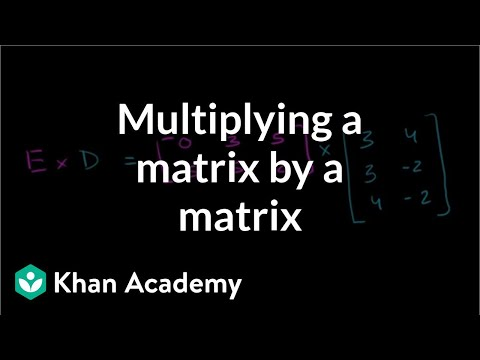

In [34]:
from IPython.display import YouTubeVideo
YouTubeVideo("OMA2Mwo0aZg", width="60%")

To summarize the video, the multiplication of two matrices $\bf{A}$ and $\bf{B}$ with dimensions $m$ by $n$ and $n$ by $p$ yields a matrix $\bf{C}$ with dimensions $m$ and $p$. To obtain an entry $c_{ij}$ of matrix $\bf{C}$ where $i$ and $j$ represent the index labels of the rows and columns, we have to calculate the dot product of the $i$th row vector of $\bf{A}$ with the $j$th column vector of $\bf{B}$. So, it makes a difference if we multiply $\bf{A}$ with $\bf{B}$ from the right or left.

When multiplying a `Matrix` with a `Vector`, we follow the convention that a `Vector` on the left is interpreted as a row vector and a `Vector` on the right as a column vector. The `Vector`'s length must match the `Matrix`'s corresponding dimension. As row and column vectors can be viewed as a `Matrix` as well, matrix-vector multiplication is a special case of matrix-matrix multiplication.

In the revised `Matrix` class, the  `.__add__()`, `.__radd__()`, `.__sub__()`, `.__rsub__()`, and `.__truediv__()` methods follow the same logic as in the `Vector` class above.

Besides implementing scalar multiplication, `.__mul__()` and `.__rmul__()` are responsible for converting `Vector`s into `Matrix`s and back. In particular, all the different ways of performing a multiplication are reduced into *one* generic form, which is a matrix-matrix multiplication. That is achieved by the `._matrix_multiply()` method, another implementation detail.

In [35]:
class Matrix:

    def __init__(self, data):
        self._entries = tuple(tuple(float(x) for x in r) for r in data)
        # ...

    def __repr__(self):
        args = ", ".join("(" + ", ".join(repr(c) for c in r) + ",)" for r in self._entries)
        return f"Matrix(({args}))"

    @property
    def n_rows(self):
        return len(self._entries)

    @property
    def n_cols(self):
        return len(self._entries[0])

    def rows(self):
        return (Vector(r) for r in self._entries)

    def cols(self):
        return (
            Vector(self._entries[r][c] for r in range(self.n_rows)) for c in range(self.n_cols)
        )

    def __iter__(self):  # adapted for brevity; uses parts of entries()
        return (self._entries[r][c] for r in range(self.n_rows) for c in range(self.n_cols))

    def __add__(self, other):
        if isinstance(other, Matrix):  # matrix addition
            if (self.n_rows != other.n_rows) or (self.n_cols != other.n_cols):
                raise ValueError("matrices must have the same dimensions")
            return Matrix((s_col + o_col for (s_col, o_col) in zip(s_row, o_row))
                          for (s_row, o_row) in zip(self._entries, other._entries))
        elif isinstance(other, numbers.Number):  # broadcasting addition
            return Matrix((c + other for c in r) for r in self._entries)
        return NotImplemented

    def __radd__(self, other):
        if isinstance(other, Vector):
            raise TypeError("vectors and matrices cannot be added")
        return self + other

    def __sub__(self, other):
        if isinstance(other, Matrix):  # matrix subtraction
            if (self.n_rows != other.n_rows) or (self.n_cols != other.n_cols):
                raise ValueError("matrices must have the same dimensions")
            return Matrix((s_col - o_col for (s_col, o_col) in zip(s_row, o_row))
                          for (s_row, o_row) in zip(self._entries, other._entries))
        elif isinstance(other, numbers.Number):  # broadcasting subtraction
            return Matrix((c - other for c in r) for r in self._entries)
        return NotImplemented

    def __rsub__(self, other):
        if isinstance(other, Vector):
            raise TypeError("vectors and matrices cannot be subtracted")
        # Reverse matrix subtraction is already handled in __sub__().
        if isinstance(other, numbers.Number):  # broadcasting subtraction
            return Matrix((other - c for c in r) for r in self._entries)
        return NotImplemented
    
    def _matrix_multiply(self, other):
        if self.n_cols != other.n_rows:
            raise ValueError("matrices must have compatible dimensions")
        return Matrix((rv * cv for cv in other.cols()) for rv in self.rows())

    def __mul__(self, other):
        if isinstance(other, numbers.Number):
            return Matrix((x * other for x in r) for r in self._entries)
        elif isinstance(other, Vector):
            return self._matrix_multiply(other.as_matrix()).as_vector()
        elif isinstance(other, Matrix):
            return self._matrix_multiply(other)
        return NotImplemented

    def __rmul__(self, other):
        if isinstance(other, numbers.Number):
            return self * other
        elif isinstance(other, Vector):
            return other.as_matrix(column=False)._matrix_multiply(self).as_vector()
        return NotImplemented

    def __truediv__(self, other):
        if isinstance(other, numbers.Number):
            return self * (1 / other)
        return NotImplemented

    def as_vector(self):
        if not (self.n_rows == 1 or self.n_cols == 1):
            raise RuntimeError("one dimension (m or n) must be 1")
        return Vector(x for x in self)

In [36]:
m = Matrix([(1, 2, 3), (4, 5, 6), (7, 8, 9)])
n = Matrix([(10, 11, 12), (13, 14, 15)])

Scalar multiplication, addition, and subtraction work as before.

In [37]:
10 * m

Matrix(((10.0, 20.0, 30.0,), (40.0, 50.0, 60.0,), (70.0, 80.0, 90.0,)))

In [38]:
(2 * m + m * 3) / 5

Matrix(((1.0, 2.0, 3.0,), (4.0, 5.0, 6.0,), (7.0, 8.0, 9.0,)))

In [39]:
m - m

Matrix(((0.0, 0.0, 0.0,), (0.0, 0.0, 0.0,), (0.0, 0.0, 0.0,)))

Matrix-matrix multiplication works if the dimensions are compatible ...

In [40]:
n * m

Matrix(((138.0, 171.0, 204.0,), (174.0, 216.0, 258.0,)))

... and results in a `ValueError` otherwise.

In [41]:
m * n

ValueError: matrices must have compatible dimensions

The same holds for matrix-vector and vector-matrix multiplication. These operations always return `Vector` instances in line with standard linear algebra. If a `Vector`'s length is not compatible with the respective dimension of a `Matrix`, we receive a `ValueError`.

In [42]:
m * v

Vector((14.0, 32.0, 50.0))

In [43]:
v * m

Vector((30.0, 36.0, 42.0))

In [44]:
n * v

Vector((68.0, 86.0))

In [45]:
v * n

ValueError: matrices must have compatible dimensions

Lastly, the broadcasting addition and subtraction also work for our `Matrix` instances.

In [46]:
m + 100

Matrix(((101.0, 102.0, 103.0,), (104.0, 105.0, 106.0,), (107.0, 108.0, 109.0,)))

In [47]:
100 - m

Matrix(((99.0, 98.0, 97.0,), (96.0, 95.0, 94.0,), (93.0, 92.0, 91.0,)))

We do not allow addition or subtraction of matrices with vectors and raise a `TypeError` instead. Alternatively, we could have implemented broadcasting here as well, just like [numpy](https://www.numpy.org/) does.

In [48]:
m + v

TypeError: vectors and matrices cannot be added

### Relational Operators

As we have seen before, two different `Vector`s with the same `._entries` do *not* compare equal. The reason is that for user-defined types Python by default only assumes two instances to be equal if they are actually the same object. This is, of course, semantically wrong for our `Vector`s and `Matrix`s.

In [49]:
v = Vector([1, 2, 3])
w = Vector([1, 2, 3])

In [50]:
v == w

False

In [51]:
v == v

True

We implement the `.__eq__()` (cf., [reference <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/reference/datamodel.html#object.__eq__)) method to control how the comparison operator `==` is carried out. For brevity, we show this only for the `Vector` class. The `.__eq__()` method exits early as soon as the first pair of entries does not match. Also, for reasons discussed in [Chapter 5 <img height="12" style="display: inline-block" src="../static/link/to_nb.png">](https://nbviewer.jupyter.org/github/webartifex/intro-to-python/blob/develop/05_numbers/01_content.ipynb#Imprecision), we compare the absolute difference of two corresponding entries to a very small `zero_threshold` that is stored as a class attribute shared among all `Vector` instances. If the `Vector`s differ in their numbers of entries, we fail loudly and raise a `ValueError`.

In [52]:
class Vector:

    zero_threshold = 1e-12

    def __init__(self, data):
        self._entries = tuple(float(x) for x in data)
        # ...

    def __repr__(self):
        args = ", ".join(repr(x) for x in self)
        return f"Vector(({args}))"

    def __len__(self):
        return len(self._entries)

    def __iter__(self):
        return iter(self._entries)

    def __eq__(self, other):
        if isinstance(other, Vector):
            if len(self) != len(other):
                raise ValueError("vectors must be of the same length")
            for x, y in zip(self, other):
                if abs(x - y) > self.zero_threshold:
                    return False  # exit early if two corresponding entries differ
            return True
        return NotImplemented

In [53]:
v = Vector([1, 2, 3])
w = Vector([1, 2, 3])

In [54]:
v == w

True

Besides `.__eq__()`, there are other special methods to implement the `!=`, `<`, `>`, `<=`, and `>=` operators, the last four of which are not semantically meaningful in the context of linear algebra.

Python implicitly creates the `!=` for us in that it just inverts the result of `.__eq__()`.

In [55]:
v = Vector([1, 2, 3])
w = Vector([1, 2, 4])

In [56]:
v == w

False

In [57]:
v != w

True

## Number Emulation

Our `Vector` and `Matrix` classes do not fully behave like a `numbers.Number` in the abstract sense. Besides the not yet talked about but useful unary `+` and `-` operators, numbers in Python usually support being passed to built-in functions like [abs() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#abs), [bin() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#bin), [bool() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#bool), [complex() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#complex), [float() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#float), [hex() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#hex), [int() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#int), and others (cf., the [reference <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types) for an exhaustive list).

To see that our classes lack simple but expected behaviors, let's try to invert the signs of all entries in the vector `v` ...

In [58]:
v

Vector((1.0, 2.0, 3.0))

In [59]:
-v

TypeError: bad operand type for unary -: 'Vector'

... or pass `v` to [abs() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#abs).

In [60]:
abs(v)

TypeError: bad operand type for abs(): 'Vector'

For our example, we decide to implement the unary `+` and `-` operators, [abs() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#abs) as the Euclidean / Frobenius norm (i.e., the [magnitude <img height="12" style="display: inline-block" src="../static/link/to_wiki.png">](https://en.wikipedia.org/wiki/Magnitude_%28mathematics%29#Euclidean_vector_space)), [bool() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#bool) to check if that norm is greater than `0` or not, and [float() <img height="12" style="display: inline-block" src="../static/link/to_py.png">](https://docs.python.org/3/library/functions.html#float) to obtain a single scalar if the vector or matrix consists of only one entry. To achieve that, we implement the `.__pos__()`, `.__neg__()`, `.__abs__()`, `.__bool__()`, and `.__float__()` methods. For brevity, we do this only for the `Vector` class.

In [61]:
import math

In [62]:
def norm(vec_or_mat):
    """Calculate the Frobenius or Euclidean norm of a matrix or vector."""
    return math.sqrt(sum(x ** 2 for x in vec_or_mat))

In [63]:
class Vector:

    def __init__(self, data):
        self._entries = tuple(float(x) for x in data)
        # ...

    def __repr__(self):
        args = ", ".join(repr(x) for x in self)
        return f"Vector(({args}))"

    def __iter__(self):
        return iter(self._entries)

    def __len__(self):
        return len(self._entries)

    def __pos__(self):
        return self

    def __neg__(self):
        return Vector(-x for x in self)

    def __abs__(self):
        return norm(self)

    def __bool__(self):
        return bool(abs(self))

    def __float__(self):
        if len(self) != 1:
            raise RuntimeError("vector must have exactly one entry to become a scalar")
        return self._entries[0]

In [64]:
v = Vector([1, 2, 3])
w = Vector([3, 4])

The unary `+` operator is not only conceptually an identity operator but simply returns the instance itself.

In [65]:
+v

Vector((1.0, 2.0, 3.0))

In [66]:
+v is v

True

In [67]:
-w

Vector((-3.0, -4.0))

The magnitude of a `Vector` is only `0` if *all* entries are `0`.

In [68]:
abs(w)

5.0

In [69]:
z = Vector([0, 0])

In [70]:
abs(z)

0.0

Only an all `0`s `Vector` is `False` in a boolean context. As mentioned in [Chapter 3 <img height="12" style="display: inline-block" src="../static/link/to_nb.png">](https://nbviewer.jupyter.org/github/webartifex/intro-to-python/blob/develop/03_conditionals/00_content.ipynb#Truthy-vs.-Falsy), commonly we view an *empty* sequence as falsy; however, as we do not allow `Vector`s without any entries, we choose the all `0`s alternative. In that regard, the `Vector` class does not behave like the built-in sequence types.

In [71]:
bool(v)

True

In [72]:
bool(z)

False

Lastly, single entry `Vector`s can be casted as scalars.

In [73]:
s = Vector([42])

In [74]:
float(s)

42.0

In [75]:
float(v)

RuntimeError: vector must have exactly one entry to become a scalar